# Ploting 3D DEM Visualizations in Python

# Introduction

One of the most awaited exercises is here! We have dealt with route analyses, image correction, choropleth maps, point maps, NDVI and others, but hardly have we ever touched how to display any spatial object as a 3D surface. Isn't it exciting or are we the only ones who like to see such kind of visualizations? When we think of 3D images in GIS, it looks like the gaming world has made advances into GIS and we harnessed it for our own needs. Starting with A. Sutherland who created the first 3D modeling software in the 1970s, 3D modeling has permeated to several industries from architecture to creating a career and academic niche for itself - 3D animation(https://www.google.com/search?client=firefox-b-d&q=history+of+3D+visualization). 3D visualization in GIS is used in the following industries(https://gis.usc.edu/blog/4-uses-of-3d-gis/): 

<ul>
    <li>City planning </li>
    <li>Building information modeling</li>
    <li>Coastal modeling and analysis</li>
    <li>Wind farm assessment</li>
   </ul>
   
Here are some advantages of 3D Visualizations in GIS so that you don't take them as simply visual aesthetics(https://www.openworldlearning.org/unlock-the-power-of-3d-gis-a-guide-to-its-fundamentals-and-benefits/). 

<ul>
    <li>They provide more detail by adding a z dimension to objects.</li>
    <li>It depicts the scale of real-world objects based on explanatory illustrations</li>
   </ul>

Now that you know about 3D DEMS and why (how) they've become quite loved in GIS, it's time we create some action. As always, and forever will be, the requisite packages have to be called or else this exercise shall still remain a dreamy idea.

In [1]:
# Packages
import os
from zipfile import ZipFile
import pandas as pd
import geopandas as gpd
import rasterio
import xarray
import rioxarray
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import fiona
import mayavi.mlab as mlab # The 3D visualization package

The `mayavi` package as commented above is responsible for 3D rendering. Now that we have the necessary packages, where is the data. For our data, we shall extract it from [ASF Alaska website](https://search.asf.alaska.edu/#/?dataset=UAVSAR), and specifically the ALOS PALSAR dataset which is the highest resolution DEM we can get at no cost. We have discussed how to download the ALOS PALSAR dataset in another tutorial but for a refresh, this [video](https://www.youtube.com/watch?v=apEoZUr7c1U&list=LL&index=5) explains everything succinctly. If you have followed the instructions from the video, look for the dataset with the ID `AP_12103_FBD_F7180_RT1` and download it. It will come as a zipped file. If you are the lazy type (as some of us at some point are) here it is for you to directly download--. 

## Loading the DEM into python

In [2]:
# Go to path of ALOS PALSAR
path = "E:/documents/gis800_articles/jupyter/3D_dem"

Now that we have defined the path to the DEM, let's open it. Remember it came as a zipfile, so we will have to extract it first.

In [3]:
# loading the temp.zip and creating a zip object
with ZipFile (os.path.join(path, 'AP_12103_FBD_F7180_RT1.zip'), 'r') as zObject:
    # Extracting all the members of the zip into a specific location.
    zObject.extractall(path=os.path.join(path, 'DEM'))

If by now you can extract zipfiles in python without resorting to using specialized software, you are on your way to becoming a python wizard. Almost. At least for the small magic tricks.

Our 3D visualization will only work with a DEM. Nothing more. So to view the files in a directory in order to retrieve the one we want, we use the `os.listdir` function like so:


In [4]:
# Read the files in the extracted directory
print("These are the ALOS_PALSAR extracted files: ", os.listdir(os.path.join(path, 'DEM', 'AP_12103_FBD_F7180_RT1')))

These are the ALOS_PALSAR extracted files:  ['AP_12103_FBD_F7180_RT1.dem.tif', 'AP_12103_FBD_F7180_RT1.geo.jpg', 'AP_12103_FBD_F7180_RT1.geo.jpg.aux.xml', 'AP_12103_FBD_F7180_RT1.geo.wld', 'AP_12103_FBD_F7180_RT1.inc_map.tif', 'AP_12103_FBD_F7180_RT1.iso.xml', 'AP_12103_FBD_F7180_RT1.kmz', 'AP_12103_FBD_F7180_RT1.ls_map.tif', 'AP_12103_FBD_F7180_RT1_HH.tif', 'AP_12103_FBD_F7180_RT1_HV.tif']


As mentioned earlier, we only need a DEM. Our file of interest is the one titled `'AP_12103_FBD_F7180_RT1.dem.tif'`. Let's load it into Jupyter without further ado. 

In [5]:
# Load it into jupyter
dem = os.path.join(path, 'DEM', 'AP_12103_FBD_F7180_RT1', 'AP_12103_FBD_F7180_RT1.dem.tif')

Although the DEM from the ASF Alaska website is good for our exercise, high resolution and perfect terrrain to stretch our 3D rendering capacity, it is too large for our computer's resources, and possibly yours too (pun intended). In other words, we want to clip it in order to go easy on our computers finite resources, which also include our graphics card. The following section highlights the process of cropping a raster.

## Cropping the DEM with a shapefile

In [8]:
# The dreaded clipping exercise
from rasterio import mask # The tool to be used for the masking operation, from rasterio

Let's load the shapefile into our environment and extract it's geometries which shall be used in the raster cropping process.

In [9]:
# Open the shapefile and extract geometries
with fiona.open("E:/documents/gis800_articles/jupyter/3D_dem/clipper.shp", 'r') as shapefile:
    shapes = [feature['geometry'] for feature in shapefile] # A list comprehension for loop think of it as
    # for feature in shapefile:
       ##return feature['geometry']

Now it's time to crop our raster. We shall use the `mask` function from rasterio.

In [12]:
# Open the raster and clip it using raster.mask
with rasterio.open(dem) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

After cropping, we get a new, albeit smaller in size raster but still retaining the metadata from the original larger raster. We are now left with one tiny exercise of updating this cropped raster's metadata.

In [13]:
# Update meta data for cropped raster
out_meta.update({'driver': "Gtiff",
                'height': out_image.shape[1],
                'width': out_image.shape[2],
                'transform': out_transform})

print(out_meta)

{'driver': 'Gtiff', 'dtype': 'int16', 'nodata': 0.0, 'width': 1884, 'height': 1480, 'count': 1, 'crs': CRS.from_epsg(32737), 'transform': Affine(12.5, 0.0, 302657.21875,
       0.0, -12.5, 9983459.25)}


Okay. Here is the thing, the new raster that we've created exists in our virtual environment but it's not saved somewhere in our computer's directory from where we can access it for use outside of our python environment. To create it in a more permanent and stable state, we shall write it to an empty file created in one of our directory. Let's proceed to create the empty file.

In [14]:
# Path to new clipped raster
clippedRaster = os.path.join(path, 'DEM', 'clippedRaster.tif') # This file is empty

If you were somehow confused earlier with the term write, we simply mean to impute the virtual raster into the empty file `clippedRaster.tif`. Think of it as writing a new story on a blank sheet of paper you had saved in your drawer (to keep it safe from the dog of course!). 

In [15]:
# Write the clipped raster to the new path defined by clippedRaster variable above
with rasterio.open(clippedRaster, 'w', **out_meta) as dest:
    dest.write(out_image) # The image to be written to the clippedRaster variable/path

## Plotting the Raster

Before we render our clipped raster in a 3D image, let's first of all view it in a 2D image. This will give us a glimpse of how it looks and a premonition of how it will appear if rendered in 3D.

Let's first load our clipped raster to our virtual environment.

In [16]:
# Open the clippedRaster file
demClipped = os.path.join(path, 'DEM', 'clippedRaster.tif')
demClipped = rasterio.open(demClipped)

Now let's display our clipped raster! Even if you have never been to this location depicted by the DEM, you can make a fair guess of what it looks like. Here is a clue: a natural tower.

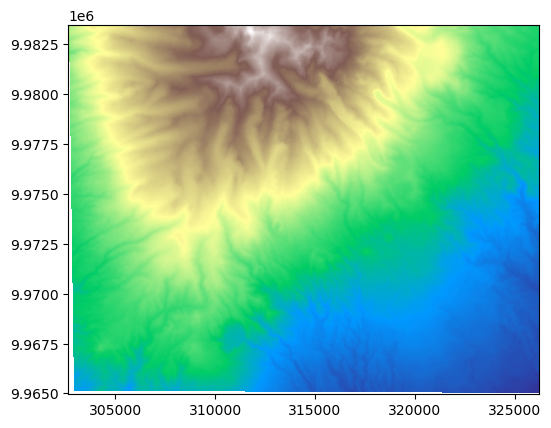

<AxesSubplot: >

In [17]:
# Display the clipped raster
from rasterio.plot import show
show(demClipped, cmap='terrain')

As a small stretch exercise for those who couldn't solve the riddle above, these contours will make things clearer. Now you can guess what our DEM represents.

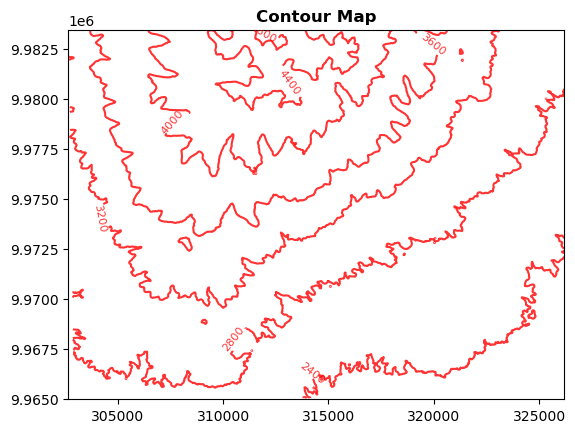

<AxesSubplot: title={'center': 'Contour Map'}>

In [18]:
# Display with contours only
show(demClipped, contour=True, title='Contour Map')

Still clueless? Our DEM is just a hived section of Mt Kenya.

We also wanted to plot our DEM with `cartopy`. The below code should work. However, if your computer is too slow to render the below image as in our case, don't blame yourself. It's the computer that needs a graphic card update, or something else.

We will first of all load the clipped DEM using a tool that will make the raster compatible with `cartopy`'s function. `cartopy` works well with rasters loaded with `rioxarray` rather than `rasterio`. 

In [19]:
# Plot the raster in cartopy
demCartopy = rioxarray.open_rasterio(os.path.join(path, 'DEM', 'clippedRaster.tif'))

In [20]:
# Some info about the clipped raster
demCartopy

<xarray.DataArray (band: 1, y: 1480, x: 1884)>
[2788320 values with dtype=int16]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 3.027e+05 3.027e+05 ... 3.262e+05 3.262e+05
  * y            (y) float64 9.983e+06 9.983e+06 ... 9.965e+06 9.965e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

To provide a focus on the area, here is the shapefile we used:

In [21]:
# Add shapefile
bounding = gpd.read_file(os.path.join(path, 'clipper.shp'))

It is from here that we shall live you on your own. Seriously. We tried every trick on the book to make the below code work, but we didn't succeed. Just ensure you have a high-tech computer to render the below image, ours was a total let down.

In [22]:
# Plot in cartopy
# fig = plt.figure(figsize=[8, 4])
# ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
# dem_image = demCartopy.plot(ax=ax)
# bounding.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4)
# plt.show()

## Plotting the DEM in 3D 

Here comes the much awaited moment. It's time to plot our DEM in 3D using `mayavi`. All protocols observed, create a title of the `mayavi` image. 

You may be asking: "Like seriously, it is time to unveil a coveted product and you ask me to first define a title?" 
"I mean, how does it help?"

For starters, `mayavi` works like a mini-software. Once you type in the commands, a small toolbox appears and in case you could be having many 3D-DEMs to visualize, a title to differentiate each will come in handy. 

"Yeah, yeah like you told me something important" You may. It's not important yes, but you save time for being orderly!

In [23]:
# Title for 3D Visualization
mlab.figure('DEM of Mt Kenya DEM')

Wait. Before you proceed, did you notice a small colorless and anonymous toolbar appear at the bottom of your screen, at the toolbar panel? That's `mayavi` called in for duty. 

Now let's call the raster we want to be 3D rendered. It is obviously our clipped raster that we saved into our directory.

In [24]:
# Open the raster to visualize
with rasterio.open(os.path.join(path, 'DEM', 'clippedRaster.tif')) as src:
    elev = src.read(1)

Our raster has been loaded. Check. But `mayavi` works with numpy arrays. This means that it works with numerical values, which our raster holds, but our clipped raster is a `.tif` not a numpy array. Luckily, because rasters are also composed of numerical values, we can extract these values, the x and y (for column and row) and the z value (for elevation). 

To get the row column values, we will use the `.shape()` method which fetches the row column dimensions of a dataset(https://www.digitalocean.com/community/tutorials/python-shape-method).

In [25]:
nrows, ncols = elev.shape

The following code will create a [rectangular grid of arrays](https://www.javatpoint.com/numpy-meshgrid#:~:text=The%20numpy%20module%20of%20Python,function%20returns%20the%20coordinate%20matrices.), with evenly spaced values using `np.arange()`. The `np.arange()` will be responsible for creating the whole list of [row column values for our matrix](https://realpython.com/how-to-use-numpy-arange/#:~:text=NumPy%20arange()%20is%20one,numpy.) derived from our clipped raster. 

The column values shall go to `x`.
The row values shall go to `y`.

In [26]:
x, y = np.meshgrid(np.arange(ncols), np.arange(nrows))

In order for our 3D model to work, it not only needs the xy coordinate values, but also the height values, which were stored into the `elev` variable.

In [27]:
z = elev

The `mlab.mesh` function of `mayavi` package plots a surface using the `x`, `y` and `z` arrays we created above(https://docs.enthought.com/mayavi/mayavi/auto/mlab_helper_functions.html#mesh).

In [28]:
mesh = mlab.mesh(x, y, z)

Here is the ultimate finale: plotting the 3D visualization of our mountain. Play around with the mlab.mesh tool, especially on the section to do with contours tab accessible from **Mayavi Pipeline > Surface > Contours**.

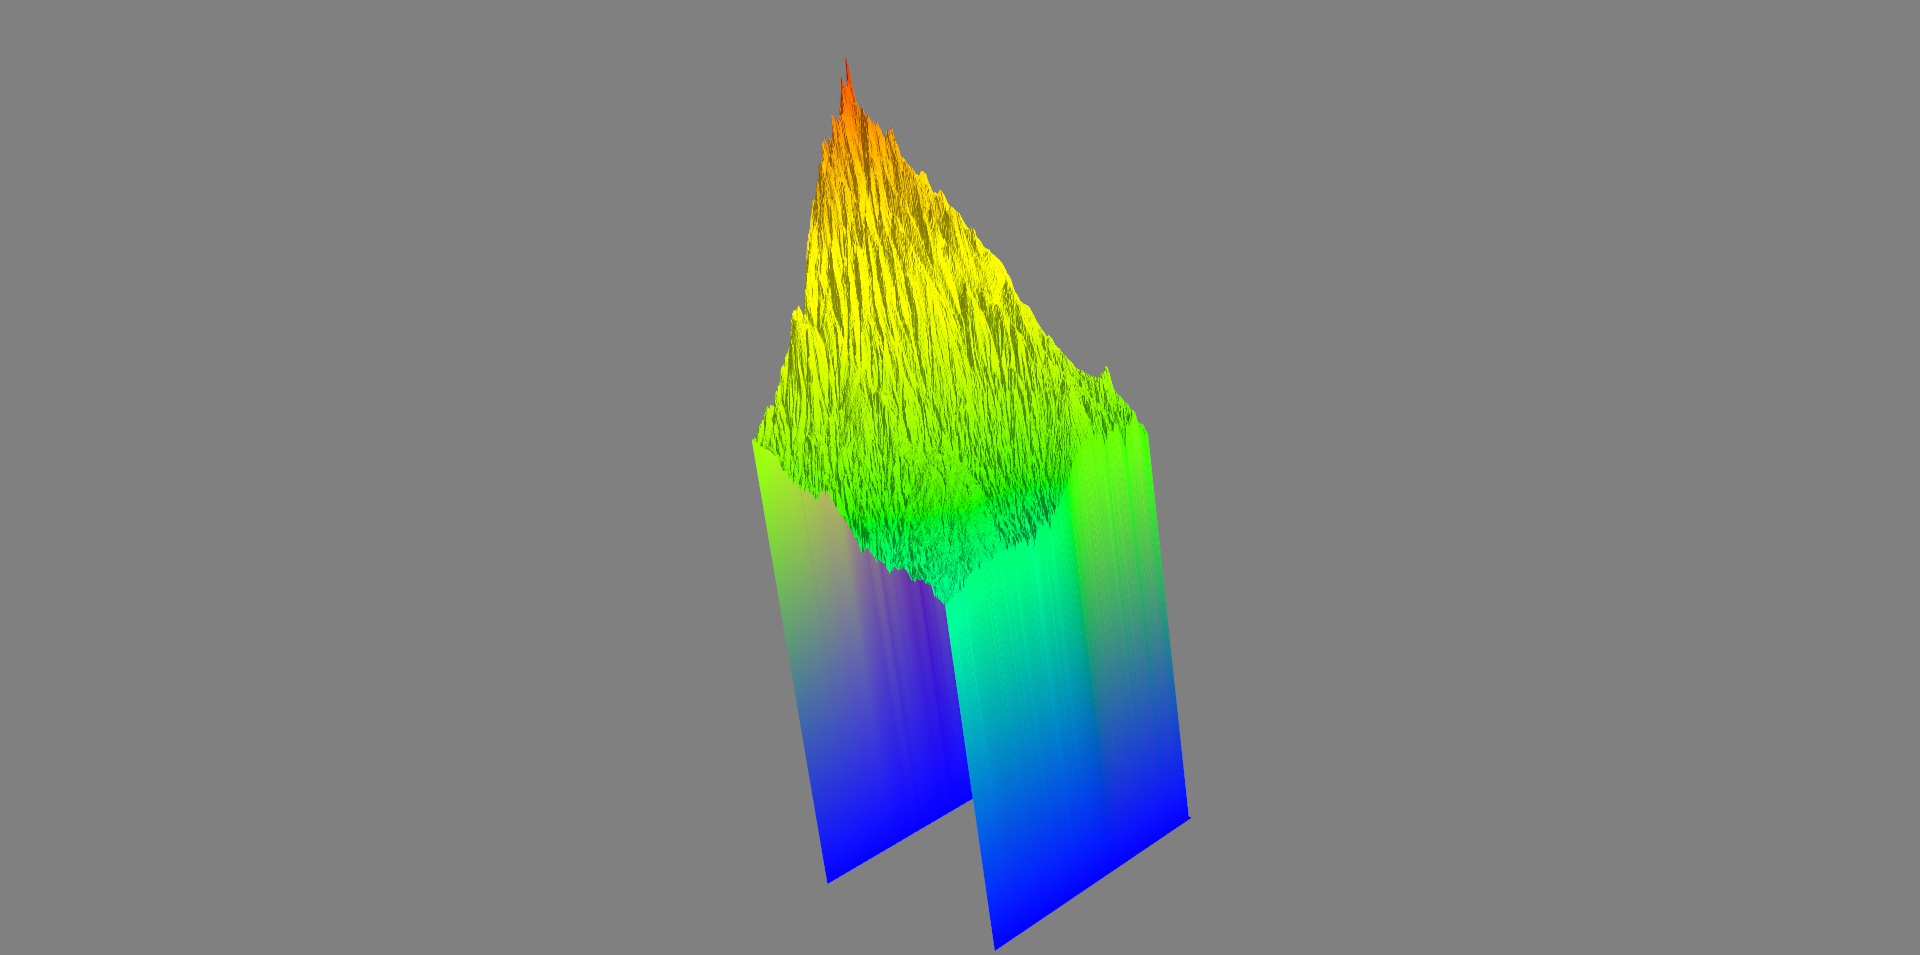

In [31]:
from IPython import display
display.Image(os.path.join(path, 'mt_kenya_3d_clipped.jpg'))

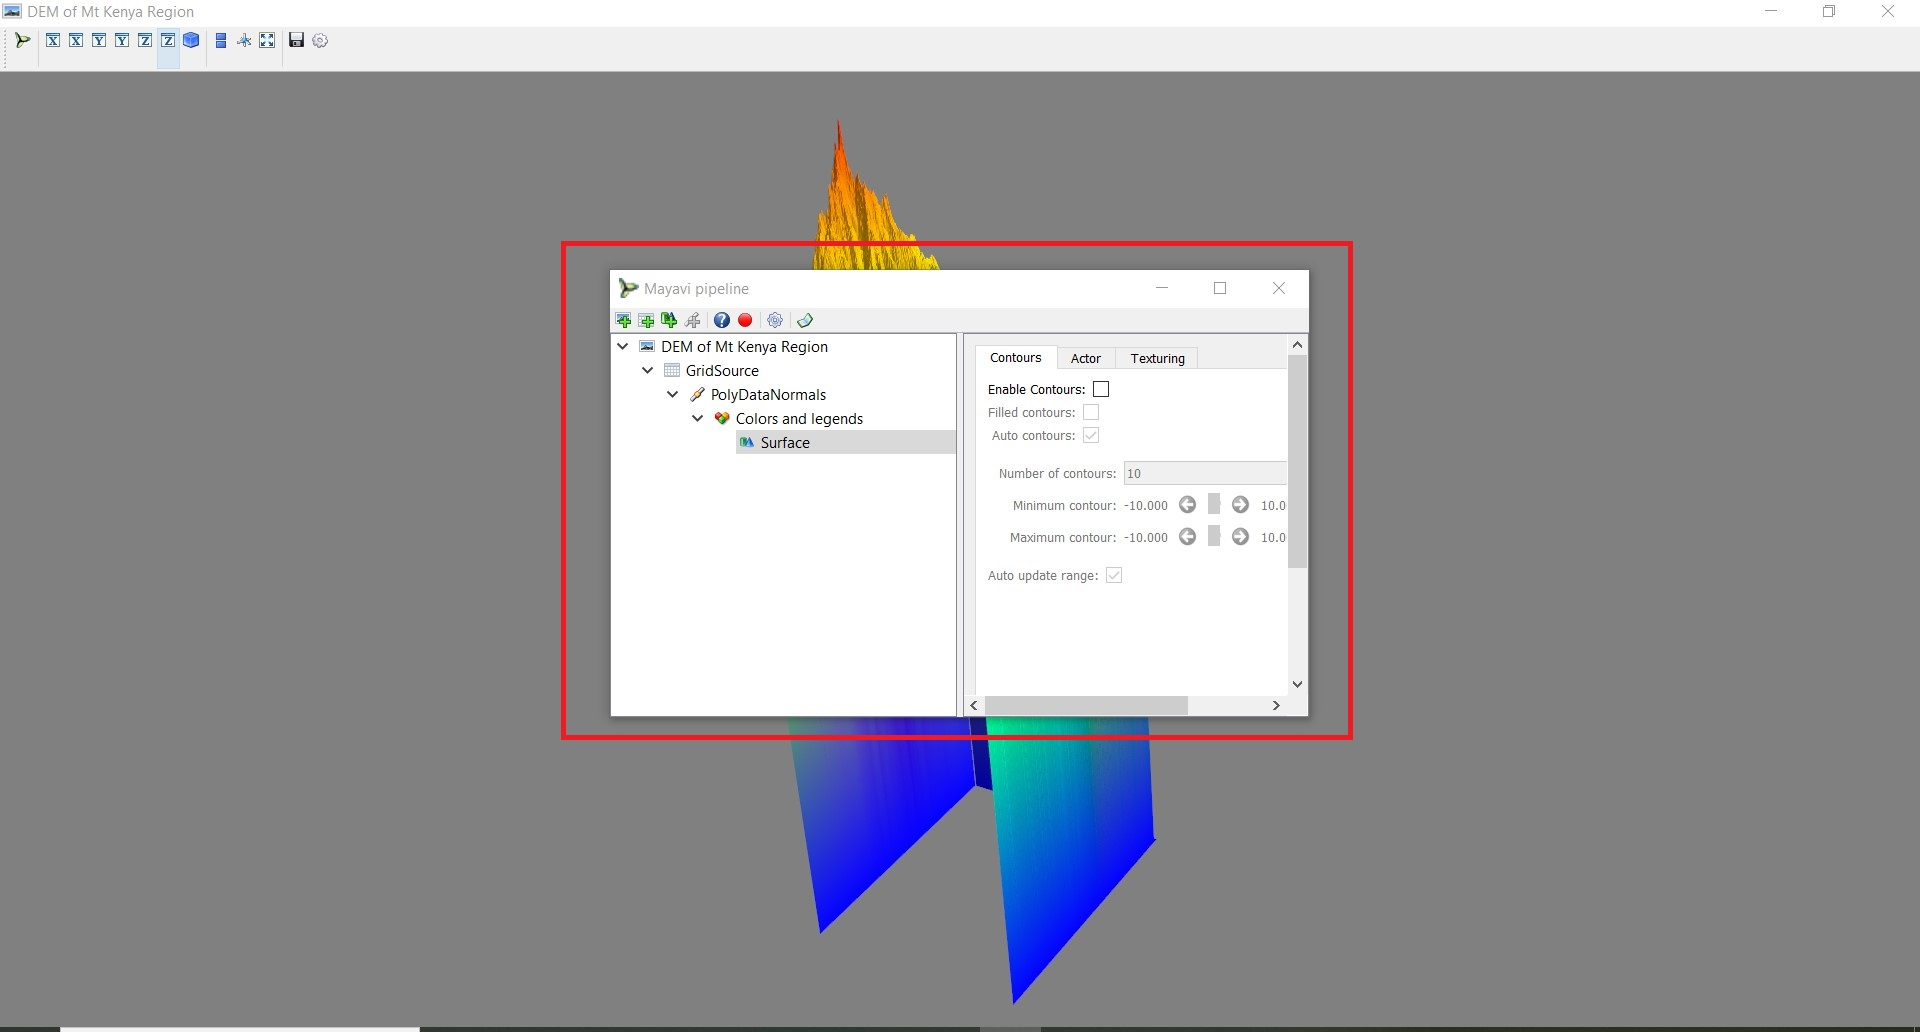

In [35]:

from IPython import display
display.Image(os.path.join(path, 'mayavi-settings.jpg'))

In [36]:
# Uncomment the below code to open the 3D visualization software
# mlab.show()

# Conclusion